In [46]:
import sys
sys.path.append("../")

from collections import OrderedDict

import kornia as korn
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.utils import make_grid

#from ul.nets import WMEncoder
from ul.data_loading import get_atari
from common.ale import ALE

In [2]:
class Encoder(nn.Module):
    """WorldModels/Dreamer/DreamerV2 -ish encoder."""

    def __init__(
        self, inp_ch, num_layers=5, base_width=48, z_ch=4, max_width=512, **kwargs
    ):
        super().__init__()

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            out_ch = min(2**i * base_width, max_width)
            self.layers.append(
                nn.Conv2d(
                    inp_ch,
                    out_ch,
                    kernel_size=4 if i <= 1 else 3,
                    stride=2 if i <= 1 else 1,
                )
            )
            inp_ch = out_ch
        self.layers.append(nn.Conv2d(inp_ch, z_ch, 1, 1))

    def forward(self, x):
        for m in self.layers[:-1]:
            x = F.relu(m(x))
        return self.layers[-1](x)


class Decoder(nn.Module):
    """WorldModels/Dreamer/DreamerV2 -ish decoder."""

    def __init__(
        self, out_ch, num_layers=5, base_width=32, z_ch=4, max_width=256, **kwargs
    ):
        super().__init__()

        self.layers = nn.ModuleList()

        out_ch_ = min(2 ** (num_layers - 1) * base_width, max_width)
        self.layers.append(nn.Conv2d(z_ch, out_ch_, 1, 1))
        z_ch = out_ch_

        ks = [(8, 1), (8, 1), (7, 1), (6, 2), (6, 2)]
        # ks = [(7, 1), (7, 1), (6, 2), (6, 2)]
        for i in range(num_layers - 1, -1, -1):

            k, s = ks[i]
            out_ch_ = min(2 ** (i - 1) * base_width, max_width)

            self.layers.append(
                nn.ConvTranspose2d(
                    z_ch,
                    out_ch if i == 0 else out_ch_,
                    kernel_size=k,
                    stride=s,
                )
            )
            z_ch = out_ch_

    def forward(self, x):
        for m in self.layers[:-1]:
            x = F.relu(m(x))
        return self.layers[-1](x)

    def mode(self):
        return self.mean

In [3]:
def th2pil(t):
    t = t.squeeze().permute(1, 2, 0) * 255
    return Image.fromarray(t.numpy().astype(np.uint8))

In [32]:
def _normalize(x):
    _min, _max = x.min(), x.max()
    return (x - _min) / (_max - _min)

In [13]:
enc = Encoder(3, z_ch=8, group_norm=False)
dec = Decoder(3)

ckpt = torch.load("../results/2022Sep01-203054_6games/0000_atari--dev/0/model_1500000.pkl")
enc_state = OrderedDict({".".join(k.split(".")[1:]):v for k,v in ckpt["model"].items() if "encoder" in k})
dec_state = OrderedDict({".".join(k.split(".")[1:]):v for k,v in ckpt["model"].items() if "decoder" in k})

enc.load_state_dict(enc_state)
dec.load_state_dict(dec_state)

<All keys matched successfully>

## Load data

In [14]:
dset = iter(get_atari("../data/6games/{0235..0300}.tar"))

In [42]:
x, sample = next(dset)

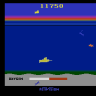

In [43]:
th2pil(x)

## Attempt decoding

In [55]:
z = enc(x.unsqueeze(0)).detach()
x_ = dec(z[:, :4]).detach()
print(x_[:4].min(), x_[:4].max())

tensor(-0.0655) tensor(1.0091)


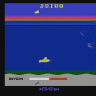

In [56]:
th2pil(_normalize(x_))

### Also check from Atari

In [52]:
env1 = ALE("SpaceInvaders", 42, "cpu", obs_dims=(96,96), obs_mode="RGB")

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [76]:
o = env1.reset()
for _ in range(200):
    o, r, d, _ = env1.step(env1.action_space.sample())
    if d:
        print("resetting")
        o = env1.reset()

In [77]:
print(o.min(), o.max())
o = o.float().div(255).squeeze(1)

tensor(0, dtype=torch.uint8) tensor(181, dtype=torch.uint8)


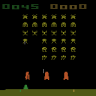

In [78]:
th2pil(o)

In [79]:
z = enc(o).detach()
o_ = dec(z[:, :4]).detach()
print(o_[:4].min(), o_[:4].max())

tensor(-0.0895) tensor(0.8203)


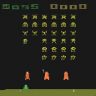

In [80]:
th2pil(_normalize(o_))

## Vizualize latents

In [49]:
z = enc(x.unsqueeze(0)).view((8, 1, 16, 16)).detach()
z = _normalize(z)

In [48]:
print(z[:4].min(), z[:4].max())

tensor(-43.4660) tensor(45.6019)


In [50]:
stuff = torch.cat([
    korn.geometry.rescale(x.unsqueeze(0), (2,2), interpolation='nearest'), 
    korn.geometry.rescale(z.expand(-1, 3, -1, -1), (12,12), interpolation='nearest')
], dim=0)

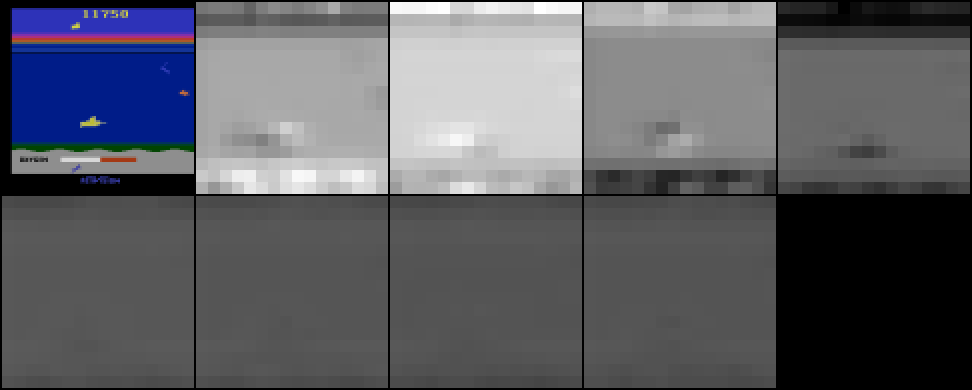

In [51]:
th2pil(make_grid(stuff, normalize=True, nrow=5))

16.0